In [2]:
# If you're in Jupyter
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
# Load the data (updated for the warning)
df = pd.read_csv("./output/mf_v3.txt", sep=r"\s+", comment="#", header=None)

# Check the shape just to be sure
print(df.shape)  # should be (n_samples, at least 4): omega_m, sigma8, prior, post

# You’ll need to check how many columns you have
# Assuming the order is: omega_m, sigma8_input, prior, posterior
df.columns = ["omega_m", "sigma8", "prior", "posterior"]

(4000, 4)


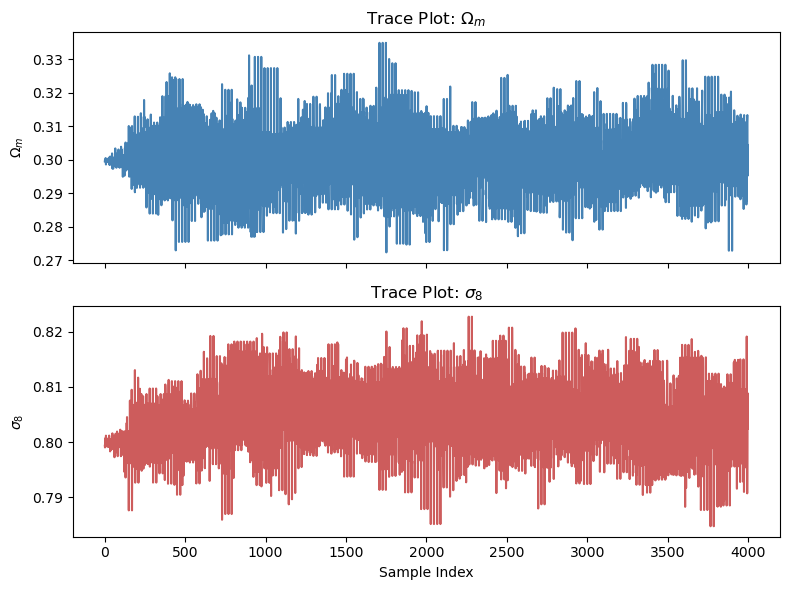

In [18]:
# Create figure with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Trace plot for omega_m
axes[0].plot(df["omega_m"], color='steelblue')
axes[0].set_ylabel(r'$\Omega_m$')
axes[0].set_title("Trace Plot: $\Omega_m$")

# Trace plot for sigma8
axes[1].plot(df["sigma8"], color='indianred')
axes[1].set_ylabel(r'$\sigma_8$')
axes[1].set_xlabel("Sample Index")
axes[1].set_title("Trace Plot: $\sigma_8$")

plt.tight_layout()
plt.show()


Removed no burn in


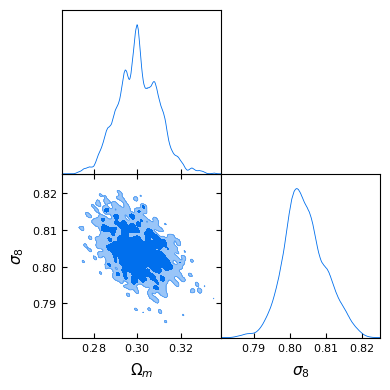

In [19]:
%matplotlib inline
from getdist import MCSamples, plots

# Extract parameter columns (adjust index if needed)
samples = df[["omega_m", "sigma8"]].values  # [omega_m, sigma_8]

# Parameter names and labels
names = ['omega_m', 'sigma8']
labels = [r'\Omega_m', r'\sigma_8']

# Create MCSamples object
mc_samples = MCSamples(samples=samples, names=names, labels=labels)

# Triangle plot
g = plots.getSubplotPlotter()
#g.settings.fine_bins_2D = 100  # default is 50
g.triangle_plot(mc_samples, filled=True)
plt.show()

Removed no burn in


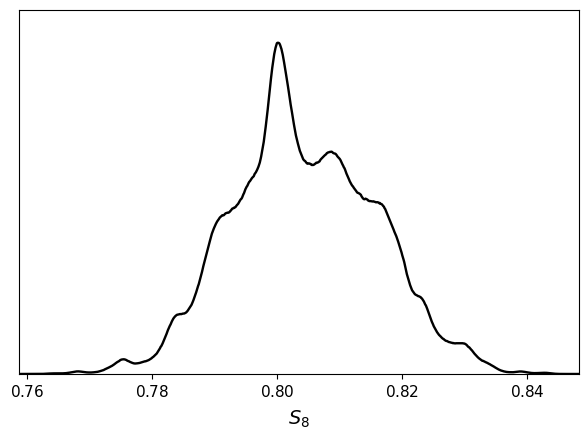

In [20]:
# --- Compute S8 ---
df["S8"] = df["sigma8"] * (df["omega_m"] / 0.3)**0.5

# --- Create MCSamples with only S8 ---
samples = df[["S8"]].values
names = ["S8"]
labels = [r"S_8"]
mc_samples = MCSamples(samples=samples, names=names, labels=labels)

# --- Plot 1D posterior ---
g = plots.getSinglePlotter()
g.plot_1d(mc_samples, "S8", filled=True)
plt.show()

Removed no burn in


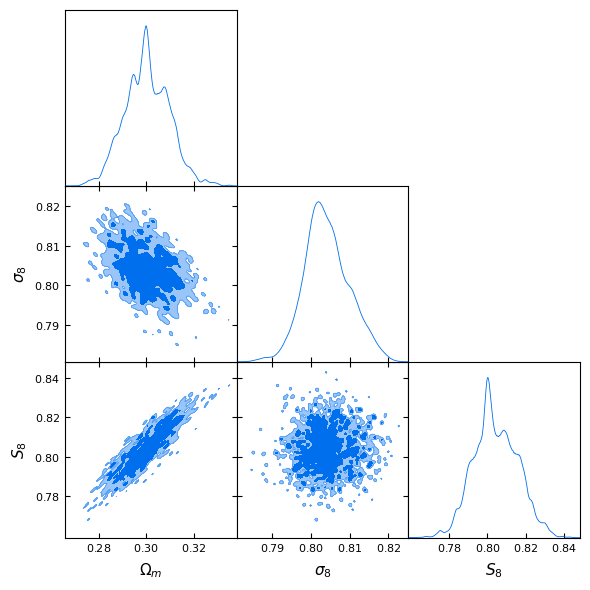

In [21]:
%matplotlib inline
from getdist import MCSamples, plots
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Compute S8 ---
df["S8"] = df["sigma8"] * (df["omega_m"] / 0.3)**0.5

# --- Step 2: Prepare samples array ---
samples = df[["omega_m", "sigma8", "S8"]].values

# --- Step 3: Parameter names and LaTeX labels ---
names = ['omega_m', 'sigma8', 'S8']
labels = [r'\Omega_m', r'\sigma_8', r'S_8']

# --- Step 4: Create MCSamples object ---
mc_samples = MCSamples(samples=samples, names=names, labels=labels)

# --- Step 5: Triangle plot ---
g = plots.getSubplotPlotter()
#g.settings.fine_bins_2D = 100  # or 150, 200 if needed
g.triangle_plot(mc_samples, filled=True)
plt.show()


/global/homes/x/xintang/anaconda3/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


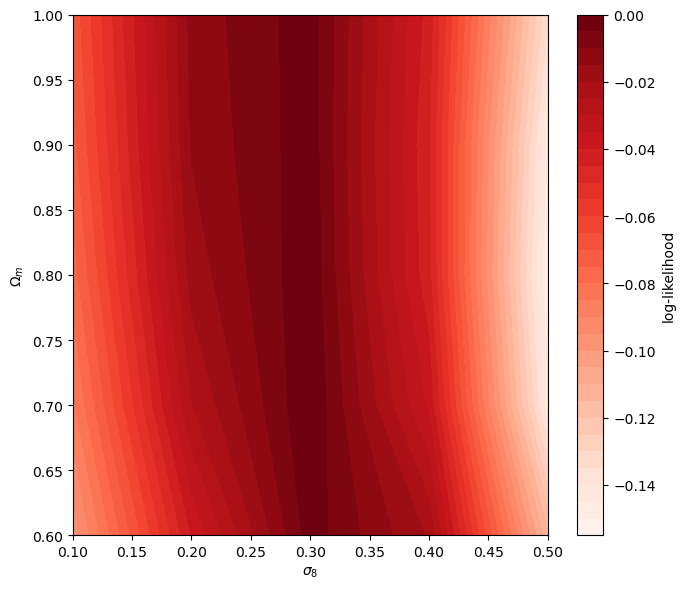

In [12]:
%matplotlib inline
from hmf import MassFunction
import scipy.interpolate

# Grid setup
omega_vals = np.linspace(0.1, 0.5, 5)
sigma_vals = np.linspace(0.6, 1.0, 5)
loglike_grid = np.zeros((len(omega_vals), len(sigma_vals)))

# Fixed data setup (same as your mock setup)
z = 0.1
mf_ref = MassFunction(z=z, sigma_8=0.81,
                      cosmo_params={"H0": 70, "Om0": 0.28, "Ob0": 0.04},
                      Mmin=13, Mmax=15, dlog10m=0.4,
                      hmf_model="Tinker08", n=0.96)
mass_obs = mf_ref.m
obs = mf_ref.dndlnm.copy()
sigma = np.maximum(0.1 * obs, 1e-3)

# Loop over grid
for i, omega in enumerate(omega_vals):
    for j, sig8 in enumerate(sigma_vals):
        mf_model = MassFunction(z=z, sigma_8=sig8,
                                cosmo_params={"H0": 70, "Om0": omega, "Ob0": 0.04},
                                Mmin=13, Mmax=15, dlog10m=0.4,
                                hmf_model="Tinker08", n=0.96)
        interp = scipy.interpolate.interp1d(np.log(mf_model.m), mf_model.dndlnm, kind="linear", bounds_error=False, fill_value="extrapolate")
        model_vals = interp(np.log(mass_obs))
        chi2 = np.sum(((obs - model_vals) / sigma) ** 2)
        loglike_grid[i, j] = -0.5 * chi2

# Plot it
plt.figure(figsize=(7, 6))
omega_mesh, sigma_mesh = np.meshgrid(sigma_vals, omega_vals)
contour = plt.contourf(sigma_mesh, omega_mesh, loglike_grid, levels=30, cmap="Reds")
plt.xlabel(r"$\sigma_8$")
plt.ylabel(r"$\Omega_m$")
plt.colorbar(contour, label="log-likelihood")
plt.tight_layout()
plt.show()

In [ ]:
#likelihood text for speeding up the process: replace quad to Gauss-Legendre integration

from numpy.polynomial.legendre import leggauss
from hmf import MassFunction
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

h = 0.7
H0 = h * 100  # km/s/Mpc
zmin = 0.3
zmax = 0.8
area_deg2 = 1000.0
Mmin_h = 5e14 / h  # Msun/h
Mmax_h = 1e15 / h # Msun/h 
sigma8 = 0.8
Om0 = 0.318

def volume_shell(zmin, zmax, Om0, area_deg2):
    """Return h^-3 Mpc^3 so it pairs with h^3 Mpc^-3 number densities."""
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    V = (cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)).to(u.Mpc**3).value
    V /= h**3                            # -> h^-3 Mpc^3
    f_sky = area_deg2 / 41253.0
    return V * f_sky

def number_density_z(z, sigma8, Om0, Mmin_h, Mmax_h):
    mf = MassFunction(
        z=z,
        sigma_8=sigma8,         # fixed fiducial
        cosmo_params={"H0": H0, "Om0": Om0},
        Mmin=np.log10(Mmin_h),
        Mmax=np.log10(Mmax_h),
        #dlog10m=0.4,
        hmf_model="Tinker08",
        #n=0.96,
    )
    
    # Mass grid (Msun/h) and dn/dM units: h^3 Mpc^-3 (Msun/h)^-1
    M = mf.m
    dM = np.gradient(M)
    n_z = np.sum(mf.dndm * dM)   # -> h^3 Mpc^-3
    return n_z

def integrate_fixed(n_z, zmin, zmax, N=12):
    x, w = leggauss(N)
    z_nodes = 0.5*(zmax - zmin)*x + 0.5*(zmax + zmin)
    weights = 0.5*(zmax - zmin)*w
    return np.sum(weights * np.array([n_z(z) for z in z_nodes]))


/global/homes/x/xintang/.local/lib/python3.11/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


N= 6 → 2.07119295e-08
N= 8 → 2.07119295e-08
N=12 → 2.07119295e-08
N=16 → 2.07119295e-08
N=20 → 2.07119295e-08
N=32 → 2.07119295e-08


In [16]:
n_z = lambda z: number_density_z(z, sigma8, Om0, Mmin_h, Mmax_h)
#N_int = integrate_fixed(n_z, zmin, zmax)
for N in [2, 4, 6, 8]:
    val = integrate_fixed(n_z, zmin, zmax, N=N)
    V = volume_shell(zmin, zmax, Om0, area_deg2)
    N_obs = V * val
    print(f"N={N:2d} → {N_obs}")

N= 2 → 118.13297403412325
N= 4 → 118.95994970485332
N= 6 → 118.95993535601576
N= 8 → 118.95993534576894
